In [5]:
%load_ext autoreload
%autoreload 2

import sys
import os
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import scipy

module_path = os.path.abspath(os.path.join('../src/'))
if module_path not in sys.path:
    sys.path.append(module_path)

from utils import *
from GSMM import *
from models_MWCq import *
check_device()
print(models_)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
CUDA is not available.
+--------------+-----------------------+
| ORGANISM     | MODEL_SBML            |
+==============+=======================+
| ECOLI_core   | e_coli_core_SBML3.xml |
+--------------+-----------------------+
| mus_musculus | mus_iMM1415.xml       |
+--------------+-----------------------+
| homo_sapiens | Recon3D.xml           |
+--------------+-----------------------+


In [6]:
'''
Load the genome scale metabolic model (GEM) from the SBML file by specifying the organism of interest
-----------
organism: {'ECOLI_core', 'mus_musculus', 'homo_sapiens'}
'''
organism = "homo_sapiens" # specify organism here

# load model from file
models_dir = os.path.abspath('../src/sbml_models/')
sbml_file = libsbml.readSBMLFromFile(os.path.join(models_dir, models[organism]))
gene_exp_scale = 100
bound_max = 1000
m_model = metabolic_model(organism, sbml_file, bound_max=bound_max)

# calculate stoichiometry matrix S and the metabolic graph G
S = m_model.S
S_matrix = m_model.S_matrix
reactions = list(m_model.reactions.keys())
metabolites = list(m_model.metabolites.keys())

S_bool = np.array(S_matrix.astype('bool').astype('int'))
S_bool = sp.csr_matrix(S_bool)
RAG = S_bool.T.dot(S_bool)
adj = RAG.astype('bool').astype('int') 
adj = adj - np.identity(adj.shape[0])
A = sp.csr_matrix(adj)
G = nx.from_scipy_sparse_array(A)

'''
___________notebook requires data to be downloaded___________
data is available for download through 
https://github.com/KrishnaswamyLab/PHATE
'''

data_temp_path = os.path.abspath('./../../../temp_data_path_EB')
with open(os.path.join(data_temp_path, 'adata_prepross_all.pk'), 'rb') as handle:
    adata = pk.load(handle)

with open(os.path.join(data_temp_path, 'data_magic.pk'), 'rb') as handle:
    data_magic = pk.load(handle)


# for interpretation of results
bigg_reactions = [rc[1] for rc in list(m_model.reactions.items())]
rx_names = pd.DataFrame([[rc.id, rc.name] for rc in bigg_reactions], columns = ['BIGG', 'name']).set_index('BIGG')

loading Recon3D.xml...
1884 genes
5835 metabolites
10600 reactions with bound max 1000


,count,mean,std,min,25%,50%,75%,max
0,10600.0,708.56,958.27,0.0,5.0,201.0,1087.25,3423.0


graph with 10600 nodes, 3755365 edges
is directed: False
is connected: False connected subgraphs: 22
has self loops: True


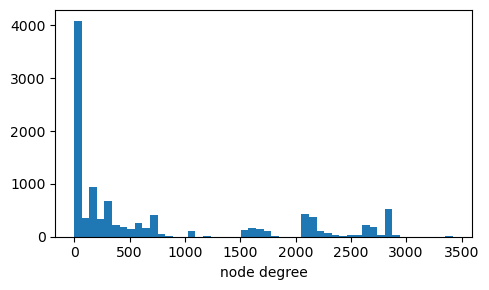

In [7]:
# see properties of metabolic graph
degrees = [val for (node, val) in G.degree()]
display(pd.DataFrame(pd.Series(degrees).describe()).transpose().round(2))
fig, ax = plt.subplots(1,1, figsize = (5,3))
ax.hist(degrees, bins=50)
ax.set_xlabel("node degree")
fig.tight_layout()

print(f'graph with {len(G.nodes)} nodes, {len(G.edges)} edges')
print(f'is directed: {G.is_directed()}')
print(f'is connected: {nx.is_connected(G)}', 
      f'connected subgraphs: {len([G.subgraph(c).copy() for c in nx.connected_components(G)])}')
print(f'has self loops: {any(G.has_edge(node, node) for node in G.nodes)}')

In [8]:
'''
we consider delta gene expression between samples and timepoint 0 (1A) control cells
'''

adata.var_names_make_unique()
dg = [g.split(" (")[0] for g in adata.var_names]
data = pd.DataFrame(data_magic, index = adata.obs_names, columns =  dg)

# calculate the delta gene expression betwee control cells
data_all = data.copy()
t0 = [str(index).__contains__('1A') for index in data.index]
ctrl = data[t0].mean()
data = data - ctrl
data.drop(data_all[t0].index, inplace=True)

# subset neuronal lineage cells
tL =[str(index).__contains__('T8') for index in data.index]
df = data[tL]
data = df
data = data[data['ONECUT2'] > 0.2]

In [9]:
# match gene names between gene expression data and GEM
model_symbol = list(m_model.genes.keys())
model_BIGG = list(m_model.genes.values())
data_genes = data.columns
matching_genes = [gene for gene in data_genes if gene in model_symbol]
model_BIGGid = [m_model.genes[i] for i in matching_genes]
df = data[matching_genes]
df.columns = model_BIGGid
data = df

In [10]:
# map gene expression to reactions
rga = 0
rnone = 0
no_gene = []
reaction_exp_matrix = {}
for i in range(0,len(m_model.reactions)):
    rc = list(m_model.reactions.values())[i]
    if rc.gene_associations is None:
        rnone += 1
        pass
    else:
        gene_association = rc.gene_associations
        try:
            rc.get_reaction_expression(data.T)
            reaction_exp_matrix[rc.id] = rc.reaction_expression
        except:
            no_gene += [i]
            rga+=1
reaction_exp_matrix = pd.DataFrame(reaction_exp_matrix)
reaction_exp_matrix = reaction_exp_matrix.fillna(0)
R = reaction_exp_matrix
srm = reaction_exp_matrix*gene_exp_scale
R, srm = merge_tx_model(m_model, R, srm)
R_full = R.copy()
srm_full = srm.copy()

In [12]:
# remove non-expressed reactions
G_ = [G.subgraph(c).copy() for c in nx.connected_components(G)]
g = G_[0]
R_all = R.copy()
srm_all = srm.copy()
R = R.loc[:,np.abs(srm).sum()>0]
srm = srm.loc[:,np.abs(srm).sum()>0]
filt_nodes = [srm_all.columns.get_loc(i) for i in srm.columns]

In [13]:
# largest fully connected graph
A_sub = A[filt_nodes][:,filt_nodes]
G = nx.from_scipy_sparse_array(A_sub)
graph = base_graph(G, m_model)
subgraphs = [g for g in nx.connected_components(graph.G)]

node_vector = []
for gsub in G_:
    node_vector.extend(list(gsub.nodes))

/Users/hollysteach/Documents/GitHub/metabolic_GNN/src/utils.py:58: UserWarning: torch.sparse.SparseTensor(indices, values, shape, *, device=) is deprecated.  Please use torch.sparse_coo_tensor(indices, values, shape, dtype=, device=). (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1695391829313/work/torch/csrc/utils/tensor_new.cpp:607.)
  return torch.sparse.FloatTensor(indices, values, shape)


In [14]:
# load preprocessed node features for metabolic graph 
input_dir = os.path.join(data_temp_path, 'MWCq_input_feat')
feat = pk_load(os.path.join(input_dir, "input_features_final.pk"))
graph.f = feat

In [15]:
# initialize data
total_samples = len(graph.f)
psd_features = []
sctdataset = []

for s in range(total_samples):
    feat = graph.f[s]
    data = Data(x=np.array(feat),edge_index=graph.edge_index)
    psd_features += (data.x.tolist())
    sctdataset += [data]

num_trainpoints = int(np.floor(0.6*total_samples))
num_valpoints = int(np.floor(num_trainpoints/3))
num_testpoints = total_samples - (num_trainpoints + num_valpoints)
traindata= sctdataset[0:num_trainpoints]
valdata = sctdataset[num_trainpoints:num_trainpoints + num_valpoints]
testdata = sctdataset[num_trainpoints + num_valpoints:]
print(len(traindata))
print(len(valdata))
print(len(testdata))

batch_size = 80

from torch.utils.data import  DataLoader
def my_collate(batch):
    data = [item for item in batch]
    return data
train_loader = DataLoader(traindata, batch_size, shuffle=True,collate_fn=my_collate)
test_loader = DataLoader(testdata, batch_size, shuffle=False,collate_fn=my_collate)
val_loader =  DataLoader(valdata, batch_size, shuffle=False,collate_fn=my_collate)

57
19
20


init model; total number of parameters: 569
Epoch:-----0
Epoch:-----1
Epoch:-----2


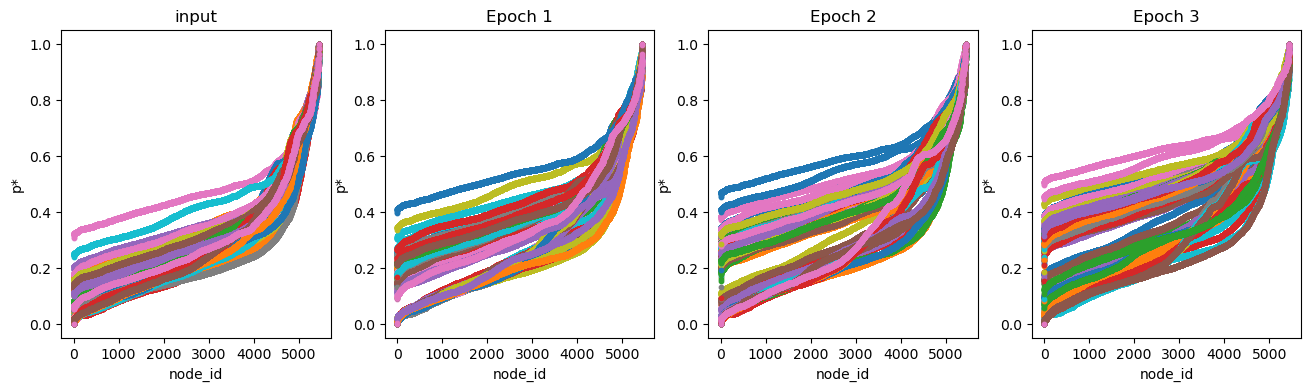

In [16]:
'''
model params
--------------------------------------------------------------------------------
order: (int) order of scattering features in each layer (J)
penalty_coefficient: weight for L2 component of loss function
'''

torch.manual_seed(1)
order = 3
N = graph.N
penalty_coefficient = 0.25
lr = 1e-4
wt_decay = 0

'''
init
--------------------------------------------------------------------------------
'''
    
model = scattering_GNN(graph,
                    input_dim =4, 
                hidden_dim=8, 
                output_dim=1, 
                n_layers=2)

optimizer = torch.optim.RMSprop(model.parameters(), lr=lr, weight_decay=wt_decay) 


'''
train
--------------------------------------------------------------------------------
'''


EPOCHS = 3

#progress
fig, axes = plt.subplots(1, (EPOCHS+1), figsize = ((EPOCHS+1)*4,4))
td = [[i,batch] for i, batch in enumerate(train_loader)]
batch = td[0][1]
plot_support(model, batch, ax=axes[0])
axes[0].set_title(f'input')

for i in range(EPOCHS):
    train(model, i, train_loader, optimizer, penalty_coefficient, verbose=False)
    
    td = [[i, batch] for i, batch in enumerate(train_loader)]
    batch = td[0][1]
    
    # Pass the subplot axes as an argument to the plot_support function
    plot_support(model, batch, ax=axes[i + 1])
    axes[i + 1].set_title(f'Epoch {i + 1}')

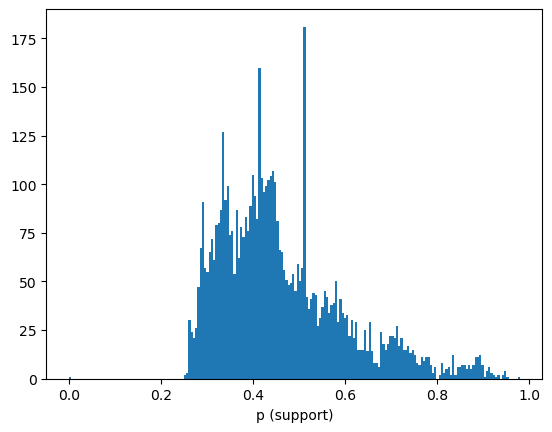

In [17]:
# evaluate model and visualize distribution of predicted likelihood each node is in the max weighted clique (p (support))
model.eval()
mwc_res = []
for d in sctdataset:
    features = torch.FloatTensor(d.x)
    output_dis = model(features)
    outs = output_dis.detach().numpy().reshape(-1,)
    mwc_res += [outs]

res = pd.DataFrame(mwc_res, columns = srm.columns)

plt.hist(np.median(res, axis = 0), bins = 200)
plt.xlabel('p (support)')
plt.show()

In [18]:
# save predictions
p_res = pd.DataFrame(np.median(res, axis = 0), index = res.columns)
p_res = pd.merge(p_res, rx_names, how= 'left', left_index=True, right_index=True)
p_res.columns = ['support', 'name']
p_res = p_res.sort_values(by= 'support', ascending=False)

res.to_csv(os.path.join(data_temp_path, 'mwcq_res_all.csv'))
p_res.to_csv(os.path.join(data_temp_path, 'mwcq_res_aggregated.csv'))